In [56]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import json 
import mplfinance as mpf

level2_deep5_filepath = '/Users/andre/Documents/Python/trading_clone_singapore_DO/trading_singapore_digitalocean/kucoin_dir/kucoin_release_data_initial/2024-12-05_10-00_GOATS/GOATS_level2Depth5_data.json'
path_to_match_file = '/Users/andre/Documents/Python/trading_clone_singapore_DO/trading_singapore_digitalocean/kucoin_dir/kucoin_release_data_initial/2024-12-05_10-00_GOATS/GOATS_match_data.json'

# level2_deep5_filepath = '/Users/andre/Documents/Python/trading_clone_singapore_DO/trading_singapore_digitalocean/kucoin_dir/kucoin_release_data_initial/2024-11-28_12-00_MGT/MGT_level2Depth5_data.json'
# path_to_match_file = '/Users/andre/Documents/Python/trading_clone_singapore_DO/trading_singapore_digitalocean/kucoin_dir/kucoin_release_data_initial/2024-11-28_12-00_MGT/MGT_match_data.json'


# level2_deep5_filepath = '/Users/andre/Documents/Python/trading_clone_singapore_DO/trading_singapore_digitalocean/kucoin_dir/kucoin_release_data_initial/2024-12-06_10-00_F/F_level2Depth5_data.json'
# path_to_match_file = '/Users/andre/Documents/Python/trading_clone_singapore_DO/trading_singapore_digitalocean/kucoin_dir/kucoin_release_data_initial/2024-12-06_10-00_F/F_match_data.json'


interval_seconds = 5

def file_to_df(file_path):
    file_path = file_path
    with open(file_path,'r')as f:
        data = json.load(f)
    df = pd.DataFrame(data['data'])
    return df


def prep_timestamp_column(df):
    """
    Prepare timestamp column by standardizing to milliseconds

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with timestamp column
    Returns:
    --------
    pandas.DataFrame
        DataFrame with converted timestamp column
    """
    # Identify the timestamp column
    possible_cols = ['time', 'timestamp']
    col_name = next((col for col in possible_cols if col in df.columns), None)
    if col_name is None:
        raise ValueError("DataFrame must contain either 'time' or 'timestamp' column")
    
    # Vectorized standardization
    def standardize_timestamps(series):
        # Convert to numeric, coercing errors to NaN
        numeric_series = pd.to_numeric(series, errors='coerce')
        # Handle NaN values
        numeric_series = numeric_series.fillna(0)
        # Convert to string and handle integer/float inputs
        ts_str = numeric_series.astype(str).str.split('.').str[0]
        # Trim long timestamps
        ts_str = ts_str.str.slice(0, 13)
        # Pad short timestamps
        ts_str = ts_str.str.pad(13, side='right', fillchar='0')
        return ts_str.astype(np.int64)
    
    # Standardize timestamps
    df['timestamp'] = standardize_timestamps(df[col_name])
    # Convert to datetime using milliseconds
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    # Drop the original column if it's different from 'timestamp'
    if col_name != 'timestamp':
        df.drop(columns=[col_name], inplace=True)
    
    return df

# load and prep deep5 data 

In [57]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame loaded from the file
df_deep5 = file_to_df(level2_deep5_filepath)
def prep_deep5_df(df):

    # Convert lists to numpy arrays
    asks_array = np.array(df['asks'].tolist(), dtype=float)
    bids_array = np.array(df['bids'].tolist(), dtype=float)
    # Access the first value of each array
    first_ask_values = asks_array[:, 0, 0]
    first_bid_values = bids_array[:, 0, 0]

    # create column with best ask and best bid and average of the two
    df['best_ask'] = first_ask_values
    df['best_bid'] = first_bid_values
    df['mean_price'] = df[['best_ask', 'best_bid']].mean(axis=1)

    # Extract prices and sizes
    ask_prices = asks_array[:, :, 0]
    ask_sizes = asks_array[:, :, 1]
    bid_prices = bids_array[:, :, 0]
    bid_sizes = bids_array[:, :, 1]

    # Calculate weighted average prices
    weighted_avg_ask_price = np.sum(ask_prices * ask_sizes, axis=1) / np.sum(ask_sizes, axis=1)
    weighted_avg_bid_price = np.sum(bid_prices * bid_sizes, axis=1) / np.sum(bid_sizes, axis=1)

    # Add the results to the DataFrame
    df['weighted_avg_ask_price'] = weighted_avg_ask_price
    df['weighted_avg_bid_price'] = weighted_avg_bid_price

    # Calculate total bid size and total ask size
    total_bid_size = np.sum(bid_sizes, axis=1)
    total_ask_size = np.sum(ask_sizes, axis=1)

    # Calculate imbalance
    imbalance = (total_bid_size - total_ask_size) / (total_bid_size + total_ask_size)

    # Add the imbalance to the DataFrame
    df['imbalance'] = imbalance
    df.drop(['asks', 'bids','time_received'], axis=1, inplace=True)
    return df

df_deep5 = prep_timestamp_column(df_deep5)
df_deep5 = prep_deep5_df(df_deep5)
df_deep5

,timestamp,best_ask,best_bid,mean_price,weighted_avg_ask_price,weighted_avg_bid_price,imbalance
0,2024-12-05 10:00:00.084,0.001400,0.001200,0.001300,0.001657,0.001020,0.545517
1,2024-12-05 10:00:00.105,0.001400,0.001200,0.001300,0.001657,0.001020,0.545517
2,2024-12-05 10:00:00.170,0.001400,0.001200,0.001300,0.001657,0.001062,0.874653
3,2024-12-05 10:00:00.270,0.001400,0.001200,0.001300,0.001658,0.001063,0.878472
4,2024-12-05 10:00:00.372,0.001400,0.001200,0.001300,0.001670,0.001071,0.881189
...,...,...,...,...,...,...,...
10983,2024-12-05 10:19:59.541,0.001108,0.001106,0.001107,0.001113,0.001102,-0.737903
10984,2024-12-05 10:19:59.649,0.001108,0.001106,0.001107,0.001113,0.001102,-0.737903
10985,2024-12-05 10:19:59.751,0.001107,0.001106,0.001106,0.001113,0.001099,-0.634301
10986,2024-12-05 10:19:59.853,0.001107,0.001099,0.001103,0.001113,0.001095,-0.756061


### aggregate 

# prep and load match data 

In [58]:


def adjust_match_columns_and_types(df):
    list_to_drop = ['sequence', 'symbol', 'tradeId', 'type', 'makerOrderId', 'takerOrderId','time_received']

    for column in list_to_drop:
        if column in df.columns:
            df = df.drop(column, axis=1)

    # Convert columns to appropriate data types
    df['price'] = df['price'].astype(float)
    df['side'] = df['side'].astype(str)
    df['size'] = df['size'].astype(float)


    return df

df_match = file_to_df(path_to_match_file)
df_match = adjust_match_columns_and_types(df_match)
df_match = prep_timestamp_column(df_match)
df_match.info()
df_match

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256 entries, 0 to 17255
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   price      17256 non-null  float64       
 1   side       17256 non-null  object        
 2   size       17256 non-null  float64       
 3   timestamp  17256 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 539.4+ KB


,price,side,size,timestamp
0,0.001500,sell,100.0,2024-12-05 10:00:00.000
1,0.001400,buy,1000.0,2024-12-05 10:00:00.242
2,0.001400,buy,3000.0,2024-12-05 10:00:00.258
3,0.001400,buy,200.0,2024-12-05 10:00:00.294
4,0.001400,buy,100000.0,2024-12-05 10:00:00.333
...,...,...,...,...
17251,0.001112,buy,276.0,2024-12-05 10:19:59.059
17252,0.001112,buy,17867.0,2024-12-05 10:19:59.059
17253,0.001115,buy,306.0,2024-12-05 10:19:59.059
17254,0.001106,sell,27648.0,2024-12-05 10:19:59.767


# aggregate match data 

In [59]:
interval_seconds =interval_seconds
def aggregate_match_data(df, interval_seconds=1):
    # Ensure we're working with a copy to avoid modifying the original DataFrame
    df = df.copy()
    # Set the timestamp as the index
    df.set_index('timestamp', inplace=True)
    
    # Resample and aggregate
    # setting coorect timestamp
    buy_volume = df[df['side'] == 'buy'].resample(f'{interval_seconds}s', label='right', closed='right')['size'].sum()
    sell_volume = df[df['side'] == 'sell'].resample(f'{interval_seconds}s', label='right', closed='right')['size'].sum()
    trade_buy = df[df['side'] == 'buy'].resample(f'{interval_seconds}s', label='right', closed='right').size()
    trade_sell = df[df['side'] == 'sell'].resample(f'{interval_seconds}s', label='right', closed='right').size()
    avg_buy_price = df[df['side'] == 'buy'].resample(f'{interval_seconds}s', label='right', closed='right')['price'].mean()
    avg_sell_price = df[df['side'] == 'sell'].resample(f'{interval_seconds}s', label='right', closed='right')['price'].mean()
    
    # Combine the results into a single DataFrame
    aggregated = pd.DataFrame({
        'trade_buy': trade_buy,
        'trade_sell': trade_sell,
        'buy_volume': buy_volume,
        'sell_volume': sell_volume,
        'avg_match_buy_price': avg_buy_price,
        'avg_match_sell_price': avg_sell_price
    }).fillna(0)
    # Reset the index to get 'interval_start' as a column
    aggregated.reset_index(inplace=True)

    # calculate the match imbalance
    aggregated['match_imbalance'] = (aggregated['buy_volume'] - aggregated['sell_volume']) / (aggregated['buy_volume'] + aggregated['sell_volume'])
    
    return aggregated

df_match_agg = aggregate_match_data(df_match, interval_seconds=interval_seconds)
df_match_agg

,timestamp,trade_buy,trade_sell,buy_volume,sell_volume,avg_match_buy_price,avg_match_sell_price,match_imbalance
0,2024-12-05 10:00:00,0.0,1,0.0,100.0,0.000000,0.001500,-1.000000
1,2024-12-05 10:00:05,120.0,58,2894428.0,1892782.0,0.001652,0.001361,0.209234
2,2024-12-05 10:00:10,30.0,106,1099187.0,1265204.0,0.001596,0.001619,-0.070216
3,2024-12-05 10:00:15,47.0,105,714751.0,2072655.0,0.001847,0.001881,-0.487157
4,2024-12-05 10:00:20,27.0,92,489856.0,1679676.0,0.002173,0.002102,-0.548422
...,...,...,...,...,...,...,...,...
236,2024-12-05 10:19:40,5.0,21,300435.0,156635.0,0.001138,0.001136,0.314613
237,2024-12-05 10:19:45,6.0,27,39439.0,258105.0,0.001131,0.001124,-0.734903
238,2024-12-05 10:19:50,9.0,66,334350.0,9392497.0,0.001122,0.001107,-0.931252
239,2024-12-05 10:19:55,60.0,90,705217.0,4256769.0,0.001101,0.001090,-0.715752


In [60]:
interval_seconds =interval_seconds
def aggregate_imbalance(df, interval_seconds=1):    
    # copy to prevent altering original df
    df_copy =df.copy()

    print(df_copy.columns)
    df_copy.set_index('timestamp', inplace=True)

    # Resample the DataFrame to the specified time interval (e.g., 10 seconds)
    resampled_df = df_copy.resample(f'{interval_seconds}s',label='right',closed='right').agg({
        'imbalance': 'mean'
    })
    resampled_df= resampled_df.reset_index()

    df_copy.drop(['imbalance'], inplace=True, axis=1)
    # merge resampled_df with original df to get aggregated imbalance 
    df_deep5_interval = pd.merge_asof(resampled_df, df_copy, on='timestamp', direction='backward')
    return df_deep5_interval


df_deep5_interval = aggregate_imbalance(df_deep5,interval_seconds)


Index(['timestamp', 'best_ask', 'best_bid', 'mean_price',
       'weighted_avg_ask_price', 'weighted_avg_bid_price', 'imbalance'],
      dtype='object')


In [61]:
df_final = pd.merge(df_match_agg, df_deep5_interval, on='timestamp', how='outer')
df_final['total_imbalance'] = df_final['match_imbalance'] + (0.8 * df_final['imbalance'])
df_final

,timestamp,trade_buy,trade_sell,buy_volume,sell_volume,avg_match_buy_price,avg_match_sell_price,match_imbalance,imbalance,best_ask,best_bid,mean_price,weighted_avg_ask_price,weighted_avg_bid_price,total_imbalance
0,2024-12-05 10:00:00,0.0,1,0.0,100.0,0.000000,0.001500,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-12-05 10:00:05,120.0,58,2894428.0,1892782.0,0.001652,0.001361,0.209234,0.921395,0.001500,0.001301,0.001401,0.001592,0.001132,0.946350
2,2024-12-05 10:00:10,30.0,106,1099187.0,1265204.0,0.001596,0.001619,-0.070216,0.903258,0.001759,0.001529,0.001644,0.001903,0.001524,0.652391
3,2024-12-05 10:00:15,47.0,105,714751.0,2072655.0,0.001847,0.001881,-0.487157,0.951534,0.002250,0.002227,0.002239,0.002309,0.002040,0.274070
4,2024-12-05 10:00:20,27.0,92,489856.0,1679676.0,0.002173,0.002102,-0.548422,0.632583,0.002300,0.002299,0.002299,0.002357,0.002248,-0.042356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,2024-12-05 10:19:40,5.0,21,300435.0,156635.0,0.001138,0.001136,0.314613,-0.519983,0.001136,0.001130,0.001133,0.001137,0.001128,-0.101374
237,2024-12-05 10:19:45,6.0,27,39439.0,258105.0,0.001131,0.001124,-0.734903,-0.497011,0.001131,0.001120,0.001125,0.001134,0.001118,-1.132512
238,2024-12-05 10:19:50,9.0,66,334350.0,9392497.0,0.001122,0.001107,-0.931252,0.250964,0.001120,0.001110,0.001115,0.001122,0.001105,-0.730481
239,2024-12-05 10:19:55,60.0,90,705217.0,4256769.0,0.001101,0.001090,-0.715752,0.219509,0.001099,0.001085,0.001092,0.001100,0.001082,-0.540145


In [62]:
interval_seconds = interval_seconds
# Function to create candlestick data
def create_candlestick_data(df, interval_seconds=1):
    # Resample the data
    ohlc_dict = {
        'mean_open': ('mean_price', 'first'),
        'mean_high': ('mean_price', 'max'),
        'mean_low': ('mean_price', 'min'),
        'mean_close': ('mean_price', 'last')
    }
    candlestick_df = df.resample(f'{interval_seconds}s',label='right',closed='right', on='timestamp').agg(**ohlc_dict)
    candlestick_df = candlestick_df.dropna()
    return candlestick_df

# Create candlestick data with a 1-minute time frame
candlestick_df = create_candlestick_data(df_deep5, interval_seconds)
candlestick_df

,mean_open,mean_high,mean_low,mean_close
timestamp,,,,
2024-12-05 10:00:05,0.001300,0.001845,0.001300,0.001401
2024-12-05 10:00:10,0.001401,0.001887,0.001339,0.001644
2024-12-05 10:00:15,0.001644,0.002249,0.001544,0.002239
2024-12-05 10:00:20,0.002061,0.002299,0.001920,0.002299
2024-12-05 10:00:25,0.002299,0.002559,0.002294,0.002555
...,...,...,...,...
2024-12-05 10:19:40,0.001141,0.001141,0.001133,0.001133
2024-12-05 10:19:45,0.001133,0.001133,0.001125,0.001125
2024-12-05 10:19:50,0.001125,0.001126,0.001109,0.001115


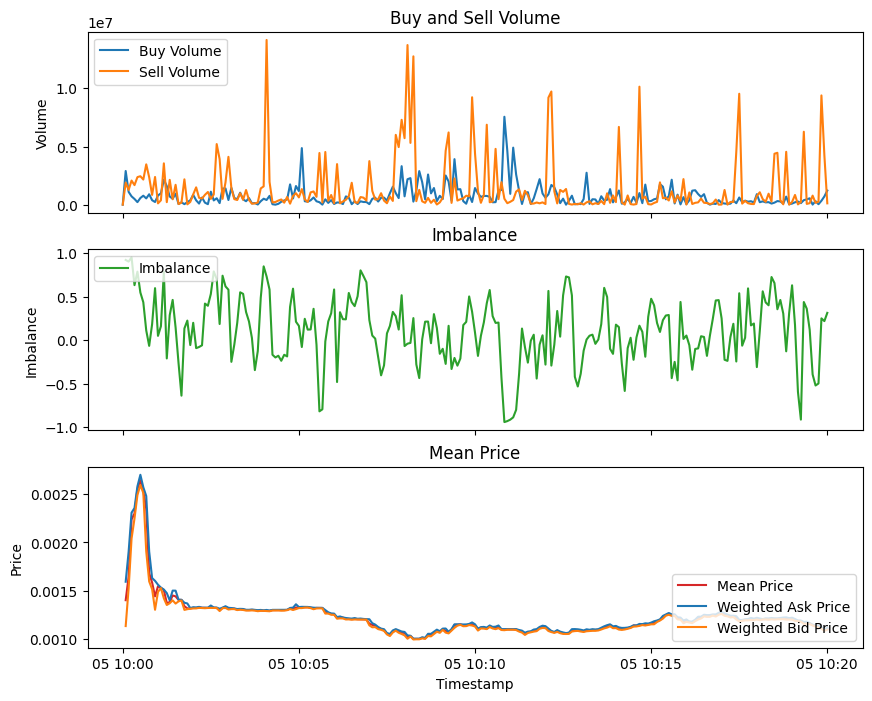

In [63]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plot df_match_agg data on the first subplot
ax1.plot(df_match_agg['timestamp'], df_match_agg['buy_volume'], label='Buy Volume', color='tab:blue')
ax1.plot(df_match_agg['timestamp'], df_match_agg['sell_volume'], label='Sell Volume', color='tab:orange')
ax1.set_ylabel('Volume')
ax1.legend(loc='upper left')
ax1.set_title('Buy and Sell Volume')

# Plot df_deep5_interval data on the second subplot
ax2.plot(df_deep5_interval['timestamp'], df_deep5_interval['imbalance'], label='Imbalance', color='tab:green')
ax2.set_ylabel('Imbalance')
ax2.legend(loc='upper left')
ax2.set_title('Imbalance')

# Plot mean price on the third subplot
ax3.plot(df_deep5_interval['timestamp'], df_deep5_interval['mean_price'], label='Mean Price', color='tab:red')
ax3.plot(df_deep5_interval['timestamp'], df_deep5_interval['weighted_avg_ask_price'], label='Weighted Ask Price', color='tab:blue')
ax3.plot(df_deep5_interval['timestamp'], df_deep5_interval['weighted_avg_bid_price'], label='Weighted Bid Price', color='tab:orange')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Price')
ax3.legend(loc='lower right')
ax3.set_title('Mean Price')

plt.show()

In [64]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with shared x-axis
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.1, 
                    subplot_titles=('Candlestick Chart', 'Volume', 'Imbalance'))

# Add candlestick chart to the first subplot
fig.add_trace(go.Candlestick(
    x=candlestick_df.index,
    open=candlestick_df['mean_open'],
    high=candlestick_df['mean_high'],
    low=candlestick_df['mean_low'],
    close=candlestick_df['mean_close'],
    name='Candlestick'
), row=1, col=1)

# Add buy_volume line to the second subplot
fig.add_trace(go.Scatter(
    x=df_match_agg['timestamp'],
    y=df_match_agg['buy_volume'],
    mode='lines',
    name='Buy Volume',
    line=dict(color='green')
), row=2, col=1)

# Add sell_volume line to the second subplot
fig.add_trace(go.Scatter(
    x=df_match_agg['timestamp'],
    y=df_match_agg['sell_volume'],
    mode='lines',
    name='Sell Volume',
    line=dict(color='red')
), row=2, col=1)

# Add imbalance line to the third subplot
fig.add_trace(go.Scatter(
    x=df_deep5_interval['timestamp'],
    y=df_final['total_imbalance'],
    mode='lines',
    name='Imbalance'
), row=3, col=1)
# Update layout for better visualization
fig.update_layout(
    title='Candlestick Chart with Volume',
    xaxis_title='Timestamp',
    yaxis_title='Mean Price',
    xaxis2_title='Timestamp',
    yaxis2_title='Volume',
    xaxis_rangeslider_visible=False,
    hovermode='x unified',  # Enable cursor lines indicating x and y axis
    width=800,  # Set the width of the chart
    height=800   # Set the height of the chart
)


# Display the chart
fig.show()

In [65]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with shared x-axis
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.1, 
                    subplot_titles=('Candlestick Chart', 'Volume', 'Imbalance', 'Prices'))

# Add candlestick chart to the first subplot
fig.add_trace(go.Candlestick(
    x=candlestick_df.index,
    open=candlestick_df['mean_open'],
    high=candlestick_df['mean_high'],
    low=candlestick_df['mean_low'],
    close=candlestick_df['mean_close'],
    name='Candlestick'
), row=1, col=1)

# Add buy_volume line to the second subplot
fig.add_trace(go.Scatter(
    x=df_match_agg['timestamp'],
    y=df_match_agg['buy_volume'],
    mode='lines',
    name='Buy Volume',
    line=dict(color='green')
), row=2, col=1)

# Add sell_volume line to the second subplot
fig.add_trace(go.Scatter(
    x=df_match_agg['timestamp'],
    y=df_match_agg['sell_volume'],
    mode='lines',
    name='Sell Volume',
    line=dict(color='red')
), row=2, col=1)

# Add average match sell price, average match buy price, weighted bid price, and weighted ask price to the fourth subplot
fig.add_trace(go.Scatter(
    x=df_deep5_interval['timestamp'],
    y=df_match_agg['avg_match_sell_price'],
    mode='lines',
    name='Avg Match Sell Price',
    line=dict(color='blue')
), row=3, col=1)

fig.add_trace(go.Scatter(
    x=df_deep5_interval['timestamp'],
    y=df_match_agg['avg_match_buy_price'],
    mode='lines',
    name='Avg Match Buy Price',
    line=dict(color='orange')
), row=3, col=1)

fig.add_trace(go.Scatter(
    x=df_deep5_interval['timestamp'],
    y=df_deep5_interval['weighted_avg_bid_price'],
    mode='lines',
    name='Weighted Bid Price',
    line=dict(color='purple')
), row=3, col=1)

fig.add_trace(go.Scatter(
    x=df_deep5_interval['timestamp'],
    y=df_deep5_interval['weighted_avg_ask_price'],
    mode='lines',
    name='Weighted Ask Price',
    line=dict(color='brown')
), row=3, col=1)

# Add imbalance line to the third subplot
fig.add_trace(go.Scatter(
    x=df_deep5_interval['timestamp'],
    y=df_deep5_interval['imbalance'],
    mode='lines',
    name='Imbalance'
), row=4, col=1)


# Update layout for better visualization
fig.update_layout(
    title='Candlestick Chart with Volume',
    xaxis_title='Timestamp',
    yaxis_title='Mean Price',
    xaxis2_title='Timestamp',
    yaxis2_title='Volume',
    xaxis3_title='Timestamp',
    yaxis3_title='Imbalance',
    xaxis4_title='Timestamp',
    yaxis4_title='Price',
    xaxis_rangeslider_visible=False,
    hovermode='x unified',  # Enable cursor lines indicating x and y axis
    width=800,  # Set the width of the chart
    height=1000   # Set the height of the chart
)

# Display the chart
fig.show()